<a href="https://colab.research.google.com/github/stellawang196/ML_Projects/blob/main/EE473_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install stockstats
!pip install shimmy
!pip install stable_baselines3
!pip install pyfolio
!pip install git+https://github.com/Stable-Baselines-Team/stable-baselines3-contrib



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.3/954.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-man

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
NVIDIA GeForce RTX 4090


In [ ]:

!pip install yfinance


In [ ]:
%pip install pyfolio-reloaded



     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ---------------------------------------- 60.6/60.6 kB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ------ --------------------------------- 0.5/3.0 MB 10.2 MB/s eta 0:00:01
     ----------------------- ---------------- 1.7/3.0 MB 18.3 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 20.9 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   ------ --------------------------------- 1.1/6.2 MB 69.6 MB/s eta 0:00:01
   ----------- ---------------------------- 1.8/6.2 MB 23.5 MB/s

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import datetime

import yfinance as yf

from stockstats import StockDataFrame as Sdf

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import DummyVecEnv

from stable_baselines3 import A2C, DDPG, PPO, TD3, SAC
from sb3_contrib import RecurrentPPO

from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
import time

from gym.utils import seeding
import gym as gym
from gym import spaces
import pickle

from pyfolio import timeseries
import pyfolio

/usr/local/lib/python3.10/dist-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)


# 1 Data Processing

In [ ]:
class StockDataProcessor:

    def __init__(self, start_date: str, end_date: str, ticker_list: list, tech_indicator_list: list):
        self.start_date = start_date
        self.end_date = end_date
        self.ticker_list = ticker_list
        self.tech_indicator_list = tech_indicator_list

    def fetch_data(self):
        # Fetch data using yfinance
        df = pd.DataFrame()
        for tic in self.ticker_list:
            temp_df = yf.download(tic, start=self.start_date, end=self.end_date)
            temp_df['tic'] = tic
            df = pd.concat([df, temp_df])

        df.reset_index(inplace=True)
        # We are using the Adj Close as our close price
        df.drop(['Close'], axis=1, inplace=True)
        df.rename(columns={'Date': 'date', 'Adj Close': 'close'}, inplace=True)
        # Format the date
        df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
        df.dropna(inplace=True)
        return df

    def preprocess_data(self, df):
        df = self.clean_data(df)
        df = self.add_technical_indicator(df)
        df = self.add_turbulence(df)
        df = df.ffill().bfill()
        return df

    def clean_data(self, data):
        df = data.sort_values(["date", "tic"], ignore_index=True)
        # Exclude stocks with any missing close prices
        pivot_close_prices = df.pivot_table(index="date", columns="tic", values="close")
        # Drop any columns (stocks) that contain NaN values in their close price series
        valid_tics = pivot_close_prices.dropna(axis=1).columns
        # Filter the original dataframe to only include tickers with complete data
        df = df[df['tic'].isin(valid_tics)]
        return df

    def add_technical_indicator(self, data):
        df = data.sort_values(by=["tic", "date"]).copy()
        stock = Sdf.retype(df.copy())

        # Get the indicator values
        for indicator in self.tech_indicator_list:
            stock.get(indicator)
            # Remove the unwanted MACD-related columns
            if indicator == 'macd':
                stock.drop(['macds', 'macdh'], axis=1, inplace=True)

        df = stock.reset_index()
        df = df.sort_values(by=["date", "tic"]).reset_index(drop=True)
        return df

    def add_turbulence(self, data):
        df = data.copy()
        turbulence_index = self.calculate_turbulence(df)
        df = df.merge(turbulence_index, on="date")
        df = df.sort_values(["date", "tic"]).reset_index(drop=True)
        return df

    def calculate_turbulence(self, data):
        df_price_pivot = data.pivot(index="date", columns="tic", values="close").pct_change()

        # Define lookback for turbulence calculation after an initial year has passed
        lookback = 252
        turbulence_indices = [0] * lookback

        for i in range(lookback, len(df_price_pivot)):
            # Get historical prices up to current date
            hist_prices = df_price_pivot.iloc[i-lookback:i]
            # Drop columns with any NaN values to maintain consistent data
            hist_prices = hist_prices.dropna(axis=1, how='any')
            # Calculate covariance matrix from historical price changes
            cov_matrix = hist_prices.cov()
            # Get most recent day's returns and adjust them by subtracting the mean returns
            current_returns = df_price_pivot.iloc[i] - hist_prices.mean()

            # Calculate the turbulence as the dot product of the inverted covariance matrix and current returns
            if not cov_matrix.empty and current_returns.dropna().shape[0] == cov_matrix.shape[0]:
                try:
                    # Calculate Mahalanobis distance as turbulence indicator
                    inv_cov_matrix = np.linalg.pinv(cov_matrix.values)
                    turbulence = np.dot(current_returns.values, np.dot(inv_cov_matrix, current_returns.values.T))
                    turbulence_indices.append(turbulence if turbulence > 0 else 0)
                except np.linalg.LinAlgError:
                    turbulence_indices.append(0)
            else:
                # If data is insufficient for covariance matrix calculation
                turbulence_indices.append(0)

        turbulence_df = pd.DataFrame({
            'date': df_price_pivot.index[lookback:],
            'turbulence': turbulence_indices[lookback:]
        })

        return turbulence_df

def data_split(df, start, end, target_date_col="date"):
    data = df[(df[target_date_col] >= start) & (df[target_date_col] < end)]
    data = data.sort_values([target_date_col, "tic"], ignore_index=True)
    data.index = data[target_date_col].factorize()[0]
    return data

In [ ]:
TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2021-01-01'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2022-06-01'

TECHNICAL_INDICATORS_LIST = ['macd', 'rsi_30', 'cci_30', 'dx_30']

DOW_30_TICKER = ['AAPL','MSFT','JPM','V','RTX','PG','GS','NKE','DIS','AXP',
                  'HD','INTC','WMT','IBM','MRK','UNH','KO','CAT','TRV','JNJ',
                  'CVX','MCD','VZ','CSCO','XOM','BA','MMM','PFE','WBA','DD']

stockDataProcessor = StockDataProcessor(start_date = TRAIN_START_DATE,
                                        end_date = TEST_END_DATE,
                                        ticker_list = DOW_30_TICKER,
                                        tech_indicator_list = TECHNICAL_INDICATORS_LIST)

df_raw = stockDataProcessor.fetch_data()
df = stockDataProcessor.preprocess_data(df_raw)

train = data_split(df, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(df, TEST_START_DATE,TEST_END_DATE)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [ ]:
df.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2010-04-01,8.478929,8.526071,8.312500,7.125055,603145200,AAPL,0.199492,65.592435,110.837982,30.206836,0.0
1,2010-04-01,41.680000,41.900002,41.360001,34.015739,6016300,AXP,0.501867,58.073426,104.372148,9.501828,0.0
2,2010-04-01,73.239998,73.510002,72.300003,57.264812,4411000,BA,1.897387,67.625171,91.083544,46.207881,0.0
3,2010-04-01,63.290001,64.199997,63.290001,44.224056,7829300,CAT,1.070035,62.304674,162.751554,19.204101,0.0
4,2010-04-01,26.200001,26.299999,25.660000,17.516590,56193700,CSCO,0.275179,56.046095,29.646136,13.966072,0.0


# 2 Environment

In [ ]:
class EnvSetup:

    def __init__(self,
        stock_dim:int,
        hmax = 100,
        initial_amount = 1000000,
        transaction_cost_pct = 0.001,
        reward_scaling = 1e-4):

        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.tech_indicator_list = TECHNICAL_INDICATORS_LIST
        # account balance + close price + shares + technical indicators
        self.state_space = 1 + 2*self.stock_dim + len(self.tech_indicator_list)*self.stock_dim
        self.action_space = self.stock_dim


    def create_env_training(self, data, env_class, turbulence_threshold=150):
        env_train = DummyVecEnv([lambda: env_class(df = data,
                                                    stock_dim = self.stock_dim,
                                                    hmax = self.hmax,
                                                    initial_amount = self.initial_amount,
                                                    transaction_cost_pct = self.transaction_cost_pct,
                                                    reward_scaling = self.reward_scaling,
                                                    state_space = self.state_space,
                                                    action_space = self.action_space,
                                                    tech_indicator_list = self.tech_indicator_list,
                                                    turbulence_threshold = turbulence_threshold)])
        return env_train

    def create_env_validation(self, data, env_class, turbulence_threshold=150):
        env_validation = DummyVecEnv([lambda: env_class(df = data,
                                            stock_dim = self.stock_dim,
                                            hmax = self.hmax,
                                            initial_amount = self.initial_amount,
                                            transaction_cost_pct = self.transaction_cost_pct,
                                            reward_scaling = self.reward_scaling,
                                            state_space = self.state_space,
                                            action_space = self.action_space,
                                            tech_indicator_list = self.tech_indicator_list,
                                            turbulence_threshold = turbulence_threshold)])
        obs_validation = env_validation.reset()


        return env_validation, obs_validation

    def create_env_trading(self, env_class, data, turbulence_threshold=150):
        env_trade = DummyVecEnv([lambda: env_class(df = data,
                                            stock_dim = self.stock_dim,
                                            hmax = self.hmax,
                                            initial_amount = self.initial_amount,
                                            transaction_cost_pct = self.transaction_cost_pct,
                                            reward_scaling = self.reward_scaling,
                                            state_space = self.state_space,
                                            action_space = self.action_space,
                                            tech_indicator_list = self.tech_indicator_list,
                                            turbulence_threshold = turbulence_threshold)])
        obs_trade = env_trade.reset()


        return env_trade, obs_trade

In [ ]:
class StockEnvTrain(gym.Env):
    """A stock training environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self,
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = -1, high = 1,shape = (self.action_space,))
        # Shape = 181: [Current Balance]+[prices 1-30]+[owned shares 1-30]
        # +[macd 1-30]+ [rsi 1-30] + [cci 1-30] + [adx 1-30]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (self.state_space,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.terminal = False
        # initalize state
        self.state = [self.initial_amount] + \
                      self.data.close.values.tolist() + \
                      [0]*self.stock_dim  + \
                      sum([self.data[tech].values.tolist() for tech in self.tech_indicator_list ], [])
        # initialize reward
        self.reward = 0
        self.cost = 0
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.trades = 0
        #self.reset()
        self._seed()


    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.state[index+self.stock_dim+1] > 0:
            #update balance
            self.state[0] += \
            self.state[index+1]*min(abs(action),self.state[index+self.stock_dim+1]) * \
             (1- self.transaction_cost_pct)

            self.state[index+self.stock_dim+1] -= min(abs(action), self.state[index+self.stock_dim+1])
            self.cost +=self.state[index+1]*min(abs(action),self.state[index+self.stock_dim+1]) * \
             self.transaction_cost_pct
            self.trades+=1
        else:
            pass


    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        available_amount = self.state[0] // self.state[index+1]
        # print('available_amount:{}'.format(available_amount))

        #update balance
        self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                          (1+ self.transaction_cost_pct)

        self.state[index+self.stock_dim+1] += min(available_amount, action)

        self.cost+=self.state[index+1]*min(available_amount, action)* \
                          self.transaction_cost_pct
        self.trades+=1

    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            #plt.plot(self.asset_memory,'r')
            #plt.savefig('results/account_value_train.png')
            #plt.close()
            end_total_asset = self.state[0]+ \
                sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))

            print("begin_total_asset:{}".format(self.asset_memory[0]))
            print("end_total_asset:{}".format(end_total_asset))
            df_total_value = pd.DataFrame(self.asset_memory)
            #df_total_value.to_csv('results/account_value_train.csv')
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))- self.initial_amount ))
            print("total_cost: ", self.cost)
            print("total_trades: ", self.trades)
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                  df_total_value['daily_return'].std()
            print("Sharpe: ",sharpe)
            print("=================================")
            df_rewards = pd.DataFrame(self.rewards_memory)
            #df_rewards.to_csv('results/account_rewards_train.csv')

            # print('total asset: {}'.format(self.state[0]+ sum(np.array(self.state[1:29])*np.array(self.state[29:]))))
            #with open('obs.pkl', 'wb') as f:
            #    pickle.dump(self.state, f)

            return self.state, self.reward, self.terminal,{}

        else:
            # print(np.array(self.state[1:29]))

            actions = actions * self.hmax
            #actions = (actions.astype(int))

            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            #print("begin_total_asset:{}".format(begin_total_asset))

            argsort_actions = np.argsort(actions)

            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])

            self.day += 1
            self.data = self.df.loc[self.day,:]
            #load next state
            # print("stock_shares:{}".format(self.state[29:]))
            self.state =  [self.state[0]] + \
                    self.data.close.values.tolist() + \
                    list(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]) + \
                    sum([self.data[tech].values.tolist() for tech in self.tech_indicator_list ], [])

            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            self.asset_memory.append(end_total_asset)
            #print("end_total_asset:{}".format(end_total_asset))

            self.reward = end_total_asset - begin_total_asset
            # print("step_reward:{}".format(self.reward))
            self.rewards_memory.append(self.reward)

            self.reward = self.reward*self.reward_scaling



        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False
        self.rewards_memory = []
        #initiate state
        self.state = [self.initial_amount] + \
                      self.data.close.values.tolist() + \
                      [0]*self.stock_dim + \
                      sum([self.data[tech].values.tolist() for tech in self.tech_indicator_list ], [])
        # iteration += 1
        return self.state

    def render(self, mode='human'):
        return self.state

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

In [ ]:
class StockEnvTrade(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self,
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold,
                day = 0, iteration=''):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        # action_space normalization and shape is self.self.stock_dim
        self.action_space = spaces.Box(low = -1, high = 1,shape = (self.action_space,))
        # Shape = 181: [Current Balance]+[prices 1-30]+[owned shares 1-30]
        # +[macd 1-30]+ [rsi 1-30] + [cci 1-30] + [adx 1-30]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (self.state_space,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.terminal = False
        self.turbulence_threshold = turbulence_threshold
        # initalize state
        self.state = [self.initial_amount] + \
                      self.data.close.values.tolist() + \
                      [0]*self.stock_dim  + \
                      sum([self.data[tech].values.tolist() for tech in self.tech_indicator_list ], [])
        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[self.data.date.unique()[0]]
        #self.reset()
        self._seed()

        self.iteration=iteration


    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.turbulence<self.turbulence_threshold:
            if self.state[index+self.stock_dim+1] > 0:
                #update balance
                self.state[0] += \
                self.state[index+1]*min(abs(action),self.state[index+self.stock_dim+1]) * \
                 (1- self.transaction_cost_pct)

                self.state[index+self.stock_dim+1] -= min(abs(action), self.state[index+self.stock_dim+1])
                self.cost +=self.state[index+1]*min(abs(action),self.state[index+self.stock_dim+1]) * \
                 self.transaction_cost_pct
                self.trades+=1
            else:
                pass
        else:
            # if turbulence goes over threshold, just clear out all positions
            if self.state[index+self.stock_dim+1] > 0:
                #update balance
                self.state[0] += self.state[index+1]*self.state[index+self.stock_dim+1]* \
                              (1- self.transaction_cost_pct)
                self.state[index+self.stock_dim+1] =0
                self.cost += self.state[index+1]*self.state[index+self.stock_dim+1]* \
                              self.transaction_cost_pct
                self.trades+=1
            else:
                pass

    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        if self.turbulence< self.turbulence_threshold:
            available_amount = self.state[0] // self.state[index+1]
            # print('available_amount:{}'.format(available_amount))

            #update balance
            self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                              (1+ self.transaction_cost_pct)

            self.state[index+self.stock_dim+1] += min(available_amount, action)

            self.cost+=self.state[index+1]*min(available_amount, action)* \
                              self.transaction_cost_pct
            self.trades+=1
        else:
            # if turbulence goes over threshold, just stop buying
            pass

    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            #plt.plot(self.asset_memory,'r')
            #plt.savefig('results/account_value_trade_{}.png'.format(self.iteration))
            #plt.close()
            df_total_value = pd.DataFrame(self.asset_memory)
            #df_total_value.to_csv('results/account_value_trade_{}.csv'.format(self.iteration))
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            print()
            print("previous_total_asset:{}".format(self.asset_memory[0]))

            print("end_total_asset:{}".format(end_total_asset))
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):61]))- self.asset_memory[0] ))
            print("total_cost: ", self.cost)
            print("total trades: ", self.trades)

            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                  df_total_value['daily_return'].std()
            print("Sharpe: ",sharpe)

            #df_rewards = pd.DataFrame(self.rewards_memory)
            #df_rewards.to_csv('results/account_rewards_trade_{}.csv'.format(self.iteration))

            # print('total asset: {}'.format(self.state[0]+ sum(np.array(self.state[1:29])*np.array(self.state[29:]))))

            return self.state, self.reward, self.terminal,{}

        else:
            # print(np.array(self.state[1:29]))
            self.date_memory.append(self.data.date.unique()[0])
            self.actions_memory.append(actions)

            actions = actions * self.hmax
            #actions = (actions.astype(int))
            if self.turbulence>=self.turbulence_threshold:
                actions=np.array([-self.hmax]*self.stock_dim)
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            #print("begin_total_asset:{}".format(begin_total_asset))

            argsort_actions = np.argsort(actions)

            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])

            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.turbulence = self.data['turbulence'].values[0]
            #print(self.turbulence)
            #load next state
            # print("stock_shares:{}".format(self.state[29:]))
            self.state =  [self.state[0]] + \
                    self.data.close.values.tolist() + \
                    list(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]) + \
                    sum([self.data[tech].values.tolist() for tech in self.tech_indicator_list ], [])


            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            self.asset_memory.append(end_total_asset)
            #print("end_total_asset:{}".format(end_total_asset))

            self.reward = end_total_asset - begin_total_asset
            # print("step_reward:{}".format(self.reward))
            self.rewards_memory.append(self.reward)

            self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        #self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[self.data.date.unique()[0]]
        #initiate state
        self.state = [self.initial_amount] + \
                      self.data.close.values.tolist() + \
                      [0]*self.stock_dim + \
                      sum([self.data[tech].values.tolist() for tech in self.tech_indicator_list ], [])


        return self.state

    def render(self, mode='human',close=False):
        return self.state

    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "daily_return": portfolio_return}
        )
        return df_account_value

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

# One model with defferent hyperparameters

## PPO Agent

In [ ]:
TRAINED_MODEL_DIR = "trained_models"
if not os.path.exists(TRAINED_MODEL_DIR):
    os.makedirs(TRAINED_MODEL_DIR)

class DRLAgentSingle:
    """Provides implementations for an DRL agent with different hyperparameters"""
    def __init__(self, env, agent_name, params, policy="MlpPolicy", timesteps=20000):
        self.env = env
        self.env.reset()
        self.agent_name = agent_name
        self.model = PPO(policy=policy, env=self.env, **params)
        self.timesteps = timesteps

    def train_model(self):
        self.env.reset()
        start = time.time()
        self.model = self.model.learn(total_timesteps=self.timesteps)
        end = time.time()
        self.model.save(f"{TRAINED_MODEL_DIR}/{self.agent_name}")
        print(f'Training time for {self.agent_name}: ', (end-start)/60,' minutes')

    def DRL_prediction(self, test_data, test_env, test_obs):
        test_env.reset()
        account_memory = []
        lstm_states = None
        episode_starts = np.ones((1,), dtype=bool)

        for i in range(len(test_data.index.unique())):
            action, _states = self.model.predict(test_obs, deterministic=True)
            test_obs, rewards, dones, info = test_env.step(action)
            if i == (len(test_data.index.unique()) - 2):
                account_memory = test_env.env_method(method_name='save_asset_memory')
        return account_memory[0]


PPO_PARAMS_LIST = [
    {"n_steps": 128, "ent_coef": 0.01, "learning_rate": 0.00025, "batch_size": 4, "verbose": 0},
    {"n_steps": 256, "ent_coef": 0.02, "learning_rate": 0.0005, "batch_size": 8, "verbose": 0},
    {"n_steps": 64, "ent_coef": 0.005, "learning_rate": 0.0001, "batch_size": 2, "verbose": 0},
    {"n_steps": 512, "ent_coef": 0.01, "learning_rate": 0.0001, "batch_size": 16, "verbose": 0},
    {"n_steps": 128, "ent_coef": 0.01, "learning_rate": 0.001, "batch_size": 32, "verbose": 0},
    {"n_steps": 256, "ent_coef": 0.02, "learning_rate": 0.0005, "batch_size": 64, "verbose": 0}
]


env_setup = EnvSetup(stock_dim=len(df['tic'].unique()))
env_train = env_setup.create_env_training(data=train, env_class=StockEnvTrain)

ppo_agents = []
for i, params in enumerate(PPO_PARAMS_LIST):
    agent = DRLAgentSingle(env=env_train, agent_name=f"PPO_{i+1}", params=params)
    ppo_agents.append(agent)

for i, agent in enumerate(ppo_agents):
    print(f"==============Model Training for PPO with PARAMS {i+1}===========")
    agent.train_model()


==============Model Training for PPO with PARAMS 1===========
begin_total_asset:1000000
end_total_asset:2564105.8245518436
total_reward:1564105.8245518436
total_cost:  245845.5691755922
total_trades:  74584
Sharpe:  0.6341070721978563
begin_total_asset:1000000
end_total_asset:4557012.864191448
total_reward:3557012.8641914483
total_cost:  189968.23207169655
total_trades:  70103
Sharpe:  0.8404251053716058
begin_total_asset:1000000
end_total_asset:3615620.85946493
total_reward:2615620.85946493
total_cost:  211521.7464233519
total_trades:  70732
Sharpe:  0.7387190452238424
begin_total_asset:1000000
end_total_asset:4174894.626318059
total_reward:3174894.626318059
total_cost:  204952.85740766607
total_trades:  69689
Sharpe:  0.8359491485227276
begin_total_asset:1000000
end_total_asset:4640878.144279954
total_reward:3640878.144279954
total_cost:  208115.90245146782
total_trades:  68825
Sharpe:  0.9611159886981067
begin_total_asset:1000000
end_total_asset:6213711.3882940635
total_reward:52137

## Backtest

In [ ]:

def get_daily_return(account_value):
    df = account_value.copy()
    df['daily_return'] = df['daily_return'].pct_change(1)
    df = df.dropna()
    sharpe = (252**0.5) * df['daily_return'].mean() / df['daily_return'].std()
    annual_return = ((df['daily_return'].mean() + 1)**252 - 1) * 100
    return df

def backtest_strat(df):
    strategy_ret = df.copy()
    strategy_ret['date'] = pd.to_datetime(strategy_ret['date'])
    strategy_ret.set_index('date', drop=False, inplace=True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts

def BackTestStats(account_value):
    df = get_daily_return(account_value)
    DRL_strat = backtest_strat(df)
    perf_func = timeseries.perf_stats
    perf_stats_all = perf_func(returns=DRL_strat,
                               factor_returns=DRL_strat,
                               positions=None, transactions=None, turnover_denom="AGB")
    return perf_stats_all


def baseline_strat(ticker, start, end):
    dji = StockDataProcessor(start_date=start, end_date=end, ticker_list=[ticker], tech_indicator_list=TECHNICAL_INDICATORS_LIST).fetch_data()
    dji['daily_return'] = dji['close'].pct_change(1)
    dow_strat = backtest_strat(dji)
    return dji, dow_strat

def BaselineStats(baseline_ticker='^DJI', baseline_start=TEST_START_DATE, baseline_end=TEST_END_DATE):
    dji, dow_strat = baseline_strat(ticker=baseline_ticker, start=baseline_start, end=baseline_end)
    perf_func = timeseries.perf_stats
    perf_stats_all = perf_func(returns=dow_strat,
                               factor_returns=dow_strat,
                               positions=None, transactions=None, turnover_denom="AGB")
    return perf_stats_all
def BackTestPlot(daily_return, baseline_start=TEST_START_DATE, baseline_end=TEST_END_DATE, baseline_ticker='^DJI'):
    df = daily_return.copy()
    df = get_daily_return(df)
    dji, dow_strat = baseline_strat(ticker=baseline_ticker, start=baseline_start, end=baseline_end)
    df['date'] = dji['date']
    df = df.dropna()
    DRL_strat = backtest_strat(df)
    with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns=DRL_strat, benchmark_rets=dow_strat, set_context=False)

def reformat_df(df, column_name):
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        if df["date"][0] == df["date"][0]:
            df.loc[1:, 'date'] = df.loc[1:, 'date'].shift(-1)
            df.at[df.index[-1], 'date'] = pd.Timestamp('2022-05-31')
        df.set_index('date', inplace=True)
    elif isinstance(df.index, pd.DatetimeIndex) == False:
        df.index = pd.to_datetime(df.index)
    df.columns = [column_name]
    return df


env_trade, obs_trade = env_setup.create_env_trading(data=trade, env_class=StockEnvTrade)

ppo_account_values = []
for i, agent in enumerate(ppo_agents):
    print(f"PPO backtest with PARAMS {i+1}")
    account_value = agent.DRL_prediction(test_data=trade, test_env=env_trade, test_obs=obs_trade)
    ppo_account_values.append(account_value)
    print()

# 显示回测统计结果
ppo_stats = []
for account_value in ppo_account_values:
    stats = BackTestStats(account_value)
    ppo_stats.append(stats)

baseline_stats = BaselineStats('^DJI', baseline_start=TEST_START_DATE, baseline_end=TEST_END_DATE)

combined_stats_single = pd.concat(ppo_stats + [baseline_stats], axis=1)
columns = [f"PPO_PARAMS_{i+1}" for i in range(len(PPO_PARAMS_LIST))] + ["DIJ"]
combined_stats_single.columns = columns
display(combined_stats_single)


PPO backtest with PARAMS 1

previous_total_asset:1000000
end_total_asset:969833.3015203325
total_reward:-30166.69847966754
total_cost:  5791.55994357897
total trades:  6329
Sharpe:  -0.06902588591283873

PPO backtest with PARAMS 2

previous_total_asset:1000000
end_total_asset:984463.9099610085
total_reward:-15536.090038991533
total_cost:  12124.635883665242
total trades:  6055
Sharpe:  0.009675763409944794

PPO backtest with PARAMS 3

previous_total_asset:1000000
end_total_asset:1190937.100913722
total_reward:190937.10091372207
total_cost:  8993.92924037
total trades:  6968
Sharpe:  0.9314284225879939

PPO backtest with PARAMS 4

previous_total_asset:1000000
end_total_asset:1046837.821353508
total_reward:46837.82135350804
total_cost:  7711.16349818404
total trades:  6305
Sharpe:  0.29862444001603167

PPO backtest with PARAMS 5

previous_total_asset:1000000
end_total_asset:1021516.2310667364
total_reward:21516.231066736393
total_cost:  5314.904793820296
total trades:  5840
Sharpe:  0.17

[*********************100%%**********************]  1 of 1 completed


,PPO_PARAMS_1,PPO_PARAMS_2,PPO_PARAMS_3,PPO_PARAMS_4,PPO_PARAMS_5,PPO_PARAMS_6,DIJ
Annual return,-0.021569,-0.011085,0.132459,0.033122,0.015270,0.079355,0.064139
Cumulative returns,-0.030167,-0.015536,0.190937,0.046838,0.021516,0.113237,0.091525
Annual volatility,0.150891,0.159241,0.144818,0.143695,0.174259,0.109544,0.148174
Sharpe ratio,-0.069026,0.009676,0.931428,0.298624,0.174113,0.751913,0.494854
Calmar ratio,-0.099511,-0.053802,1.056645,0.134295,0.063141,0.569700,0.425547
Stability,0.003659,0.061180,0.643602,0.184776,0.021776,0.526057,0.190809
Max drawdown,-0.216752,-0.206025,-0.125358,-0.246633,-0.241834,-0.139292,-0.150722
Omega ratio,0.988017,1.001687,1.174352,1.055156,1.030164,1.143409,1.087538
Sortino ratio,-0.092657,0.013004,1.337478,0.408414,0.237175,1.044972,0.682265
Skew,-0.479654,-0.488897,-0.200059,-0.463887,-0.400783,-0.415897,NaN


## Plot

[*********************100%%**********************]  1 of 1 completed


<Figure size 1500x500 with 0 Axes>

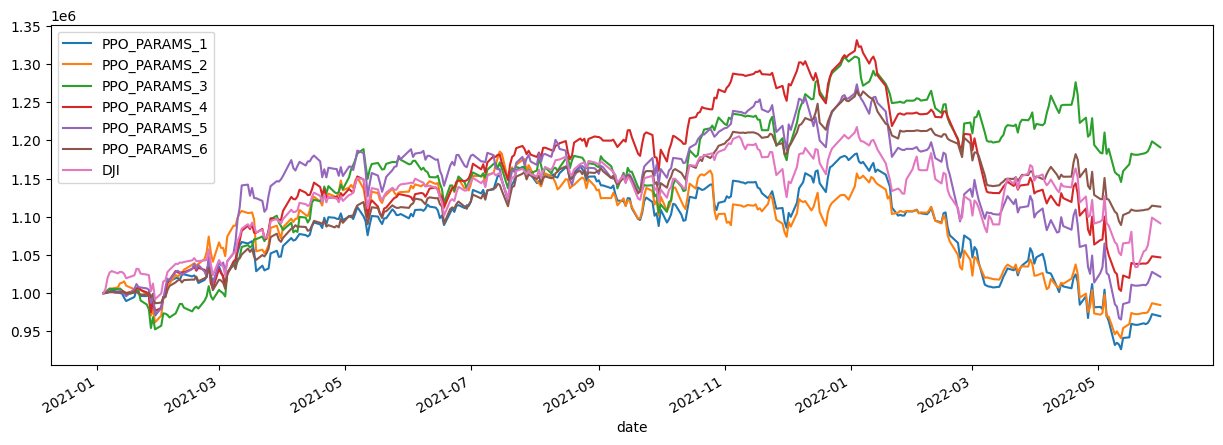

In [ ]:
dji_value = StockDataProcessor(start_date=TEST_START_DATE, end_date=TEST_END_DATE, ticker_list=["^DJI"], tech_indicator_list=TECHNICAL_INDICATORS_LIST).fetch_data()
dji_value = dji_value[["date", "close"]]
fst_day_price = dji_value["close"][0]
dji_account_value = pd.merge(dji_value['date'], dji_value['close'].div(fst_day_price).mul(1000000), how='outer', left_index=True, right_index=True).set_index('date')

daily_returns_single = pd.DataFrame()
for i, account_value in enumerate(ppo_account_values):
    formatted_df = reformat_df(account_value, f"PPO_PARAMS_{i+1}")
    daily_returns_single = pd.concat([daily_returns_single, formatted_df], axis=1)

dji_account_value = reformat_df(dji_account_value, "DJI")
daily_returns_single = pd.concat([daily_returns_single, dji_account_value], axis=1)

plt.rcParams["figure.figsize"] = (15, 5)
plt.figure()
daily_returns_single.plot()
plt.show()


# Mutiple Agents

## Agent

In [ ]:
# Show the state and action space
stock_dimension = len(df.tic.unique())
state_space = 1 + 2*stock_dimension + len(TECHNICAL_INDICATORS_LIST)*stock_dimension
action_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}, Action Space: {action_space}")

Stock Dimension: 30, State Space: 181, Action Space: 30


In [ ]:
MODELS = {"TD3": TD3, "PPO": PPO, "A2C": A2C, "DDPG": DDPG, "RecurrentPPO": RecurrentPPO, "SAC":SAC}
MODEL_PARAMS = {"TD3": {"batch_size":128,        # Minibatch size for each gradient update
                        "buffer_size":50000,     # Size of the replay buffer
                        "learning_rate":0.0001,
                        "action_noise": NormalActionNoise(mean=np.zeros(action_space), sigma=0.1*np.ones(action_space)),
                        "verbose":0},
                "PPO": {"n_steps": 128,          # The number of steps to run for each environment per update
                        "ent_coef":0.01,         # Entropy coefficient for the loss calculation
                        "learning_rate": 0.00025,
                        'batch_size':4,          # Minibatch size
			            'verbose':0},
                "A2C": {"n_steps": 5,            # The number of steps to run for each environment per update (i.e. batch size is n_steps * n_env where n_env is number of environment copies running in parallel)
                        "ent_coef":0.01,         # Entropy coefficient for the loss calculation
                        "learning_rate": 0.0007,
                        "verbose": 0},
                "DDPG": {"batch_size":128,       # Minibatch size for each gradient update
                        "buffer_size":50000,     # Size of the replay buffer
                        "action_noise": OrnsteinUhlenbeckActionNoise(mean=np.zeros(action_space), sigma=float(0.5)*np.ones(action_space)),
                        "verbose":0},
                "RecurrentPPO": {"verbose":0,
                                 "batch_size": 128},
                "SAC": {"learning_rate": 0.0001,
                        "verbose":0,
                        "batch_size": 128}
                }
TRAINED_MODEL_DIR = f"trained_models"

In [ ]:
class DRLAgent:
    """Provides implementations for an DRL agent"""
    def __init__(self, env, agent_name, params, policy="MlpPolicy", timesteps=20000):
        self.env = env
        self.env.reset()
        self.agent_name = agent_name
        self.model = MODELS[agent_name](policy=policy, env=self.env, **params)
        self.timesteps = timesteps

    def train_model(self):
        self.env.reset()
        start = time.time()
        self.model = self.model.learn(total_timesteps=self.timesteps)
        end = time.time()
        self.model.save(f"{TRAINED_MODEL_DIR}/{self.agent_name}")
        print(f'Training time for {self.agent_name}: ', (end-start)/60,' minutes')

    def DRL_prediction(self, test_data, test_env, test_obs):
        test_env.reset()
        account_memory = []
        lstm_states = None
        episode_starts = np.ones((1,), dtype=bool)

        for i in range(len(test_data.index.unique())): # number of days to trade
            if (self.agent_name == "RecurrentPPO"):
                action, lstm_states = self.model.predict(test_obs, state=lstm_states, episode_start=episode_starts, deterministic=True)
                test_obs, rewards, dones, info = test_env.step(action)
                #episode_starts = dones
            else:
                action, _states = self.model.predict(test_obs, deterministic=True)
                test_obs, rewards, dones, info = test_env.step(action)

            if i == (len(test_data.index.unique()) - 2): # do i need to consider early termination?
                account_memory = test_env.env_method(method_name = 'save_asset_memory')

        return account_memory[0]

## Train

In [ ]:
# Show the state and action space
stock_dimension = len(df.tic.unique())
state_space = 1 + 2*stock_dimension + len(TECHNICAL_INDICATORS_LIST)*stock_dimension
action_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}, Action Space: {action_space}")

Stock Dimension: 30, State Space: 181, Action Space: 30


In [ ]:
# Build the training environment
env_setup = EnvSetup(stock_dim = len(df['tic'].unique()))

env_train = env_setup.create_env_training(data = train,
                                          env_class = StockEnvTrain)

In [ ]:
# Train SAC Agent
sac_agent = DRLAgent(env=env_train, agent_name="SAC", params=MODEL_PARAMS["SAC"])

print("==============Model Training for SAC===========")
sac_agent.train_model()

==============Model Training for SAC===========
begin_total_asset:1000000
end_total_asset:5022527.488971956
total_reward:4022527.488971956
total_cost:  18004.799082976297
total_trades:  41941
Sharpe:  0.8692750114379199
begin_total_asset:1000000
end_total_asset:3303534.9078486045
total_reward:2303534.9078486045
total_cost:  112814.15868351888
total_trades:  50122
Sharpe:  0.6702467293642064
begin_total_asset:1000000
end_total_asset:3073922.952961781
total_reward:2073922.952961781
total_cost:  173187.17843393516
total_trades:  60726
Sharpe:  0.6170248872639645
begin_total_asset:1000000
end_total_asset:3472862.2615326135
total_reward:2472862.2615326135
total_cost:  156256.73248501748
total_trades:  70537
Sharpe:  0.671825056999571
begin_total_asset:1000000
end_total_asset:4354388.174397251
total_reward:3354388.1743972506
total_cost:  76463.3686436054
total_trades:  60671
Sharpe:  0.7386159132595479
begin_total_asset:1000000
end_total_asset:4499010.703811658
total_reward:3499010.703811657

In [ ]:
# Train A2C Agent
a2c_agent = DRLAgent(env=env_train, agent_name="A2C", params=MODEL_PARAMS["A2C"])

print("==============Model Training for A2C===========")
a2c_agent.train_model()


==============Model Training for A2C===========
begin_total_asset:1000000
end_total_asset:4386847.210124835
total_reward:3386847.2101248354
total_cost:  167268.74564720798
total_trades:  67936
Sharpe:  0.9258722456442974
begin_total_asset:1000000
end_total_asset:2891168.553972801
total_reward:1891168.5539728012
total_cost:  34817.379344307985
total_trades:  56677
Sharpe:  0.6718717887078801
begin_total_asset:1000000
end_total_asset:4131958.5895948745
total_reward:3131958.5895948745
total_cost:  50984.13911000178
total_trades:  57784
Sharpe:  0.8505378706062429
begin_total_asset:1000000
end_total_asset:9515877.73973601
total_reward:8515877.73973601
total_cost:  57701.03530720759
total_trades:  56486
Sharpe:  1.208302504206462
begin_total_asset:1000000
end_total_asset:5066423.820593654
total_reward:4066423.820593654
total_cost:  11699.417922840492
total_trades:  51565
Sharpe:  0.9820586611014825
begin_total_asset:1000000
end_total_asset:4033081.791678285
total_reward:3033081.791678285
to

In [ ]:
# Train TD3 Agent
td3_agent = DRLAgent(env=env_train, agent_name="TD3", params=MODEL_PARAMS["TD3"])

print("==============Model Training for TD3===========")
td3_agent.train_model()

==============Model Training for TD3===========
begin_total_asset:1000000
end_total_asset:3229004.5173083846
total_reward:2229004.5173083846
total_cost:  6265.819945127785
total_trades:  51205
Sharpe:  0.6933011598211074
begin_total_asset:1000000
end_total_asset:3643900.4086439703
total_reward:2643900.4086439703
total_cost:  1029.9592257472327
total_trades:  48677
Sharpe:  0.7664129554175789
begin_total_asset:1000000
end_total_asset:3640701.577123696
total_reward:2640701.577123696
total_cost:  998.9956032640225
total_trades:  48726
Sharpe:  0.7697450679001373
begin_total_asset:1000000
end_total_asset:3643839.0316321347
total_reward:2643839.0316321347
total_cost:  998.9981699337283
total_trades:  48726
Sharpe:  0.7711234004539421
begin_total_asset:1000000
end_total_asset:3639779.9921750054
total_reward:2639779.9921750054
total_cost:  999.0002167390735
total_trades:  48726
Sharpe:  0.7692538229801523
begin_total_asset:1000000
end_total_asset:3670921.3322643647
total_reward:2670921.332264

In [ ]:
# Traing DDPG Agent
ddpg_agent = DRLAgent(env=env_train, agent_name="DDPG", params=MODEL_PARAMS["DDPG"])

print("==============Model Training for DDPG===========")
ddpg_agent.train_model()

==============Model Training for DDPG===========
begin_total_asset:1000000
end_total_asset:2077824.930912828
total_reward:1077824.930912828
total_cost:  5488.662102561872
total_trades:  51285
Sharpe:  0.45356994440230386
begin_total_asset:1000000
end_total_asset:2846833.2981238477
total_reward:1846833.2981238477
total_cost:  6811.963753545747
total_trades:  36623
Sharpe:  0.5889965674824725
begin_total_asset:1000000
end_total_asset:4722799.355555595
total_reward:3722799.355555595
total_cost:  3341.953986384658
total_trades:  34899
Sharpe:  0.8441622468705251
begin_total_asset:1000000
end_total_asset:2855105.416337503
total_reward:1855105.4163375031
total_cost:  5910.6779865841545
total_trades:  38265
Sharpe:  0.6342415157409952
begin_total_asset:1000000
end_total_asset:2796465.8152510147
total_reward:1796465.8152510147
total_cost:  3446.6211202562176
total_trades:  37245
Sharpe:  0.581434139716234
begin_total_asset:1000000
end_total_asset:4386680.13167898
total_reward:3386680.13167898


In [ ]:
# Traing PPO Agent
ppo_agent = DRLAgent(env=env_train, agent_name="PPO", params=MODEL_PARAMS["PPO"])

print("==============Model Training for PPO===========")
ppo_agent.train_model()

==============Model Training for PPO===========
begin_total_asset:1000000
end_total_asset:3112672.0046975836
total_reward:2112672.0046975836
total_cost:  287270.7604692977
total_trades:  77398
Sharpe:  0.6515887073054532
begin_total_asset:1000000
end_total_asset:4013235.732089578
total_reward:3013235.732089578
total_cost:  154414.05115202023
total_trades:  67752
Sharpe:  0.7696168160055136
begin_total_asset:1000000
end_total_asset:1743547.4539258594
total_reward:743547.4539258594
total_cost:  129140.31926961002
total_trades:  64379
Sharpe:  0.3657534615257373
begin_total_asset:1000000
end_total_asset:1872648.072003837
total_reward:872648.072003837
total_cost:  100262.91049848084
total_trades:  60658
Sharpe:  0.39523576937106775
begin_total_asset:1000000
end_total_asset:3611240.9538293853
total_reward:2611240.9538293853
total_cost:  177996.82844293833
total_trades:  66949
Sharpe:  0.688849246411715
begin_total_asset:1000000
end_total_asset:2161240.4418238
total_reward:1161240.4418238
to

In [ ]:
# Train Recurrent PPO Agent
rec_ppo_agent = DRLAgent(env=env_train, agent_name="RecurrentPPO", params=MODEL_PARAMS["RecurrentPPO"], policy="MlpLstmPolicy")

print("==============Model Training for Recurrent PPO===========")
rec_ppo_agent.train_model()


==============Model Training for Recurrent PPO===========
begin_total_asset:1000000
end_total_asset:3925677.801170455
total_reward:2925677.801170455
total_cost:  279813.34082120017
total_trades:  77124
Sharpe:  0.8053852166772818
begin_total_asset:1000000
end_total_asset:5138088.292756842
total_reward:4138088.2927568424
total_cost:  246697.4943385029
total_trades:  74375
Sharpe:  0.8961120480537258
begin_total_asset:1000000
end_total_asset:4900378.085959197
total_reward:3900378.085959197
total_cost:  230211.4488377172
total_trades:  73290
Sharpe:  0.8940378194882803
begin_total_asset:1000000
end_total_asset:3866504.716402463
total_reward:2866504.716402463
total_cost:  177165.01761651065
total_trades:  68798
Sharpe:  0.6910422392953686
begin_total_asset:1000000
end_total_asset:2990958.0577188465
total_reward:1990958.0577188465
total_cost:  170276.28392831428
total_trades:  66944
Sharpe:  0.6069121159257539
begin_total_asset:1000000
end_total_asset:5730621.770543849
total_reward:4730621.

## Backtest

In [ ]:
# utils

## Get the backtest statistics for DRL algorithms
def get_daily_return(account_value):
    df = account_value.copy()
    df['daily_return']=df.daily_return.pct_change(1)
    df=df.dropna()
    sharpe = (252**0.5)*df['daily_return'].mean()/ \
    df['daily_return'].std()

    annual_return = ((df['daily_return'].mean()+1)**252-1)*100
    # print("annual return: ", annual_return)
    # print("sharpe ratio: ", sharpe)
    return df

def backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['date'] = pd.to_datetime(strategy_ret['date'])
    strategy_ret.set_index('date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts


def BackTestStats(account_value):
    # df = daily_return.copy()
    df = get_daily_return(account_value)
    DRL_strat = backtest_strat(df)
    perf_func = timeseries.perf_stats
    perf_stats_all = perf_func( returns=DRL_strat,
                                factor_returns=DRL_strat,
                                 positions=None, transactions=None, turnover_denom="AGB")
    # print(perf_stats_all)
    return perf_stats_all


## Get the baseline statistics for Dow Jones Index
def baseline_strat(ticker, start, end):
    dji = StockDataProcessor(start_date = start,
                             end_date = end,
                             ticker_list = [ticker],
                             tech_indicator_list=TECHNICAL_INDICATORS_LIST).fetch_data()
    dji['daily_return']=dji['close'].pct_change(1)
    dow_strat = backtest_strat(dji)
    return dji, dow_strat

def BaselineStats(baseline_ticker = '^DJI',
                  baseline_start = TEST_START_DATE,
                  baseline_end = TEST_END_DATE):

    dji, dow_strat = baseline_strat(ticker = baseline_ticker,
                                    start = baseline_start,
                                    end = baseline_end)
    perf_func = timeseries.perf_stats
    perf_stats_all = perf_func(returns=dow_strat,
                               factor_returns=dow_strat,
                               positions=None, transactions=None, turnover_denom="AGB")
    # print(perf_stats_all)
    return perf_stats_all

# Plot backtest statistics
def BackTestPlot(daily_return,
                 baseline_start = TEST_START_DATE,
                 baseline_end = TEST_END_DATE,
                 baseline_ticker = '^DJI'):

    df = daily_return.copy()
    df = get_daily_return(df)

    dji, dow_strat = baseline_strat(ticker = baseline_ticker,
                                    start = baseline_start,
                                    end = baseline_end)
    df['date'] = dji['date']
    df=df.dropna()

    DRL_strat = backtest_strat(df)

    with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=dow_strat, set_context=False)

# def reformat_df(df, column_name):
#     df = df.copy().set_index("date")
#     df.columns = [column_name]
#     df = df[~df.index.duplicated(keep='first')]
#     return df

def reformat_df(df, column_name):

    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        if df["date"][0] == df["date"][0]:
            df.loc[1:, 'date'] = df.loc[1:, 'date'].shift(-1)
            df.at[df.index[-1], 'date'] = pd.Timestamp('2022-05-31')
        df.set_index('date', inplace=True)

    elif isinstance(df.index, pd.DatetimeIndex) == False:
        df.index = pd.to_datetime(df.index)


    df.columns = [column_name]

    return df

In [ ]:
# Build testing environment
env_trade, obs_trade = env_setup.create_env_trading(data = trade,
                                         env_class = StockEnvTrade)

In [ ]:
# Get the testing result
print("SAC backtest")
sac_account_value = sac_agent.DRL_prediction(test_data = trade, test_env = env_trade, test_obs=obs_trade)
print()

print("A2C backtest")
a2c_account_value = a2c_agent.DRL_prediction(test_data = trade, test_env = env_trade, test_obs=obs_trade)
print()

print("TD3 backtest")
td3_account_value = td3_agent.DRL_prediction(test_data = trade, test_env = env_trade, test_obs=obs_trade)
print()

print("DDPG backtest")
ddpg_account_value = ddpg_agent.DRL_prediction(test_data = trade, test_env = env_trade, test_obs=obs_trade)
print()

print("PPO backtest")
ppo_account_value = ppo_agent.DRL_prediction(test_data = trade, test_env = env_trade, test_obs=obs_trade)
print()

print("Recurrent_PPO backtest")
rec_ppo_account_value = rec_ppo_agent.DRL_prediction(test_data = trade, test_env = env_trade, test_obs=obs_trade)

SAC backtest

previous_total_asset:1000000
end_total_asset:1032692.9437523066
total_reward:32692.94375230663
total_cost:  5869.58125316363
total trades:  5886
Sharpe:  0.2192543247399899

A2C backtest

previous_total_asset:1000000
end_total_asset:1108388.1385863558
total_reward:108388.13858635584
total_cost:  10979.532219039262
total trades:  6003
Sharpe:  0.5513013049231745

TD3 backtest

previous_total_asset:1000000
end_total_asset:1174348.6306646809
total_reward:174348.63066468085
total_cost:  6544.827504913334
total trades:  6372
Sharpe:  0.924142449824733

DDPG backtest

previous_total_asset:1000000
end_total_asset:1185456.0828653784
total_reward:185456.08286537835
total_cost:  6130.430608669287
total trades:  4248
Sharpe:  0.9017223196353032

PPO backtest

previous_total_asset:1000000
end_total_asset:1123554.2883996547
total_reward:123554.28839965467
total_cost:  7115.282946289007
total trades:  6006
Sharpe:  0.6902451096657086

Recurrent_PPO backtest

previous_total_asset:100000

In [ ]:
# Show the backtesting statistics
sac_stats = BackTestStats(sac_account_value)
a2c_stats = BackTestStats(a2c_account_value)
td3_stats = BackTestStats(td3_account_value)
ddpg_stats = BackTestStats(ddpg_account_value)
ppo_stats = BackTestStats(ppo_account_value)
rec_ppo_stats = BackTestStats(rec_ppo_account_value)

baseline_stats = BaselineStats('^DJI',
                                baseline_start = TEST_START_DATE,
                                baseline_end = TEST_END_DATE)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
combined_stats = pd.concat([sac_stats, a2c_stats, td3_stats,  ddpg_stats, ppo_stats, rec_ppo_stats, baseline_stats], axis=1)
combined_stats.columns = ["SAC", "A2C", "TD3", "DDPG", "PPO", "RecurrentPPO", "DIJ"]
display(combined_stats)

,SAC,A2C,TD3,DDPG,PPO,RecurrentPPO,DIJ
Annual return,0.023165,0.076006,0.121208,0.128747,0.086466,0.074752,0.064139
Cumulative returns,0.032693,0.108388,0.174349,0.185456,0.123554,0.106574,0.091525
Annual volatility,0.171435,0.154544,0.133453,0.146167,0.132965,0.166683,0.148174
Sharpe ratio,0.219254,0.551301,0.924142,0.901722,0.690245,0.515751,0.494854
Calmar ratio,0.107811,0.400322,0.830422,1.033029,0.469836,0.335529,0.425547
Stability,0.022884,0.198526,0.557584,0.711894,0.363410,0.139826,0.190809
Max drawdown,-0.214866,-0.189861,-0.145959,-0.124630,-0.184034,-0.222788,-0.150722
Omega ratio,1.037922,1.097069,1.170600,1.168614,1.129699,1.092177,1.087538
Sortino ratio,0.303290,0.759840,1.295480,1.288076,0.958655,0.733000,0.682265
Skew,-0.304361,-0.361164,-0.411463,-0.262762,-0.446849,-0.170041,NaN


## Plot

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
dji_value = StockDataProcessor(start_date = TEST_START_DATE,
                            end_date = TEST_END_DATE,
                            ticker_list = ["^DJI"],
                            tech_indicator_list=TECHNICAL_INDICATORS_LIST).fetch_data()
dji_value = dji_value[["date", "close"]]
fst_day_price = dji_value["close"][0]
dji_account_value = pd.merge(dji_value['date'], dji_value['close'].div(fst_day_price).mul(1000000),
               how='outer', left_index=True, right_index=True).set_index('date')



[*********************100%%**********************]  1 of 1 completed


In [ ]:
sac_account_value = reformat_df(sac_account_value, "SAC")
a2c_account_value = reformat_df(a2c_account_value, "A2C")
td3_account_value = reformat_df(td3_account_value, "TD3")
ddpg_account_value = reformat_df(ddpg_account_value, "DDPG")
ppo_account_value = reformat_df(ppo_account_value, "PPO")
rec_ppo_account_value = reformat_df(rec_ppo_account_value, "RecurrentPPO")
dji_account_value = reformat_df(dji_account_value, "DJI")

In [ ]:
daily_returns = pd.concat([sac_account_value, a2c_account_value, td3_account_value, ddpg_account_value, ppo_account_value, rec_ppo_account_value, dji_account_value], axis=1)
# daily_returns.columns = ["A2C", "TD3", "DDPG", "PPO", "DIJ"]

<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

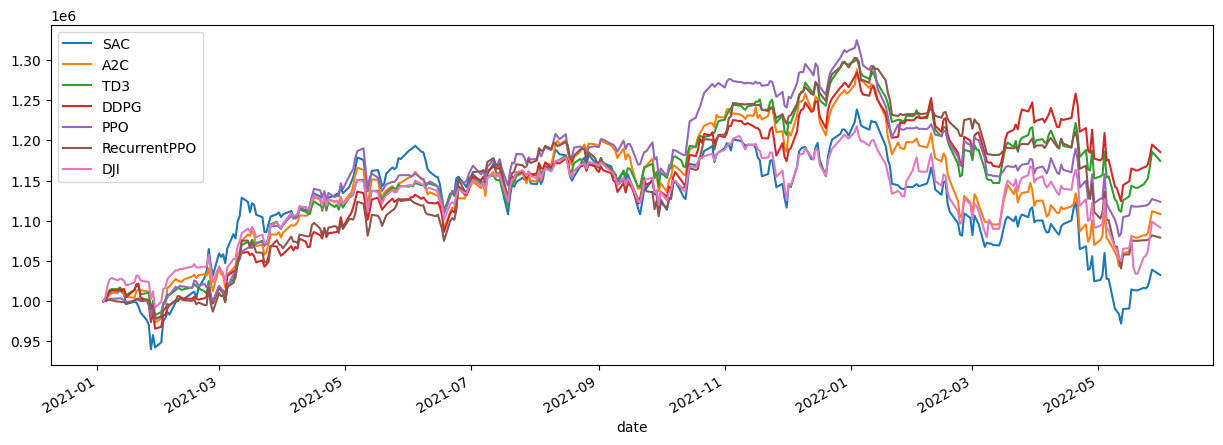

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
daily_returns.plot()